In [1]:
import gzip
import pickle
import os.path as op

import numpy as np
from nilearn import image, masking, plotting
import matplotlib.pyplot as plt

decoder_dir = op.abspath("../results/gradient_decoding")

In [2]:
def get_features(decoder):
    topic_word_weights = decoder.p_word_g_topic_
    n_topics = topic_word_weights.shape[1]
    vocabulary = np.array(decoder.vocabulary)
    sorted_weights_idxs = np.argsort(-topic_word_weights, axis=0)
    top_tokens = [
        "_".join(vocabulary[sorted_weights_idxs[:, topic_i]][:3])
        for topic_i in range(n_topics)
    ]
    features = [f"{i + 1}_{top_tokens[i]}" for i in range(n_topics)]
    return features

def gen_association(old_features, new_features):
    old_new_association = np.zeros((len(old_features), len(new_features)))
    for topic_i, old_feature in enumerate(old_features):
        old_words = old_feature.split("_")[1:]
        for word_k, old_word in enumerate(old_words):
            for topic_j, new_feature in enumerate(new_features):
                new_words = new_feature.split("_")[1:]
                if (word_k == 0) and (old_word == new_words[0]):
                    old_new_association[topic_i, topic_j] += 1
                elif old_word in new_words:
                    old_new_association[topic_i, topic_j] += 1
    return old_new_association

def match_topics(old_new_association, n_features):
    column_max = old_new_association.max(axis=1)
    topics_matched = []
    for topic_i in range(n_features):
        matche_i = np.where(old_new_association[topic_i,:] == column_max[topic_i])
        topics_matched.append(matche_i[0])
    return topics_matched

def plot_topic_assc(
    topics_matched, 
    old_meta_maps_imgs, 
    old_features, 
    new_meta_maps_imgs, 
    new_features,
    old_branch_names,
    new_branch_names,
):
    threshold=0.00001
    for topic_i, topic_matched in enumerate(topics_matched):
        fig, axes_tpl = plt.subplots(1, 3)
        plt.subplots_adjust(left=0,
                    bottom=0,
                    right=1,
                    top=1,
                    wspace=0.1,
                    hspace=0)
        fig.set_size_inches(20, 3)

        feature_img_3d = image.index_img(old_meta_maps_imgs, topic_i)
        cut_slices = plotting.find_cuts.find_xyz_cut_coords(feature_img_3d, None, None)

        plotting.plot_stat_map(
            feature_img_3d,
            draw_cross=False,
            cut_coords=cut_slices,
            colorbar=False,
            annotate=True,
            threshold=threshold,
            axes=axes_tpl[0],
        )
        axes_tpl[0].set_title(f"{old_branch_names}: {old_features[topic_i]}")
        axes_tpl[2].set_axis_off()

        for topic_j in range(topic_matched.shape[0]):
            if topic_j > 1:
                break

            feature_img_3d = image.index_img(new_meta_maps_imgs, topic_matched[topic_j])
            plotting.plot_stat_map(
                feature_img_3d,
                draw_cross=False,
                cut_coords=cut_slices,
                colorbar=False,
                annotate=True,
                threshold=threshold,
                axes=axes_tpl[topic_j+1],
            )
            axes_tpl[topic_j+1].set_title(f"{new_branch_names}: {new_features[topic_matched[topic_j]]}")

        plt.show()

# Main (seed=1) vs Main (seed=2)

In [3]:

main1_decoder_fn = op.join(decoder_dir, "source-gclda_dset-neurosynth_branch-main_iter-01000_seed-1_model.pkl.gz")
main2_decoder_fn = op.join(decoder_dir, "source-gclda_dset-neurosynth_branch-main_iter-01000_seed-2_model.pkl.gz")

main1_decoder_file = gzip.open(main1_decoder_fn, "rb")
main1_decoder = pickle.load(main1_decoder_file)

main2_decoder_file = gzip.open(main2_decoder_fn, "rb")
main2_decoder = pickle.load(main2_decoder_file)

main1_features = get_features(main1_decoder)
main2_features = get_features(main2_decoder)
main1_main2_association = gen_association(main1_features, main2_features)
n_features = len(main1_features)
topics_matched = match_topics(main1_main2_association, n_features)

main1_meta_maps_imgs = masking.unmask(main1_decoder.p_voxel_g_topic_.T, main1_decoder.mask)
main2_meta_maps_imgs = masking.unmask(main2_decoder.p_voxel_g_topic_.T, main2_decoder.mask)

/Users/jperaza/Documents/envs/gradec_env/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


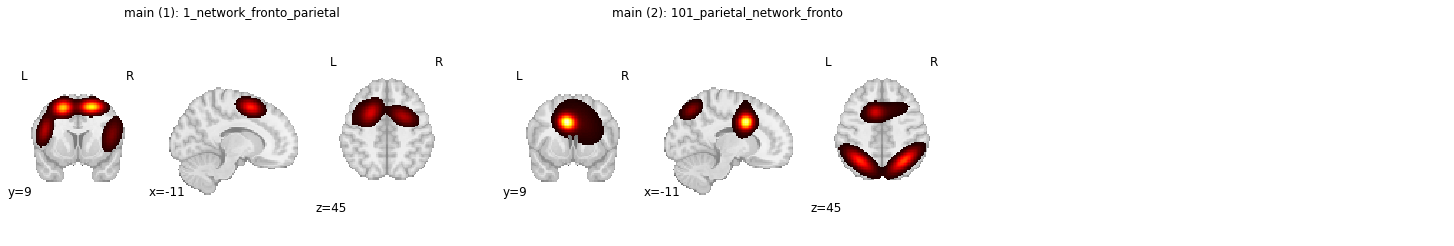

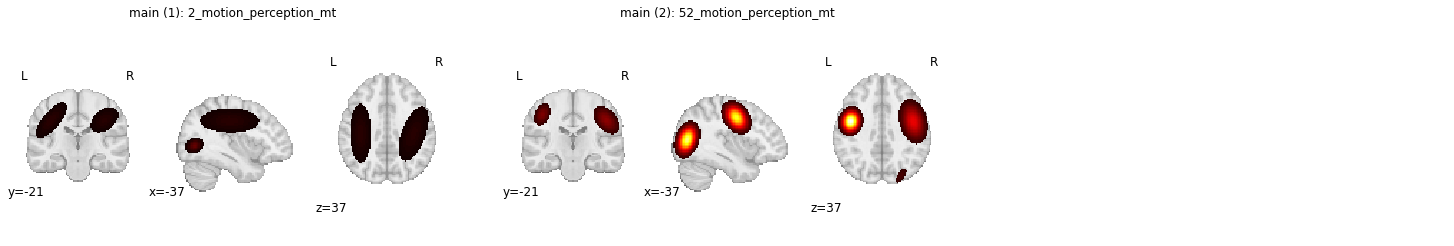

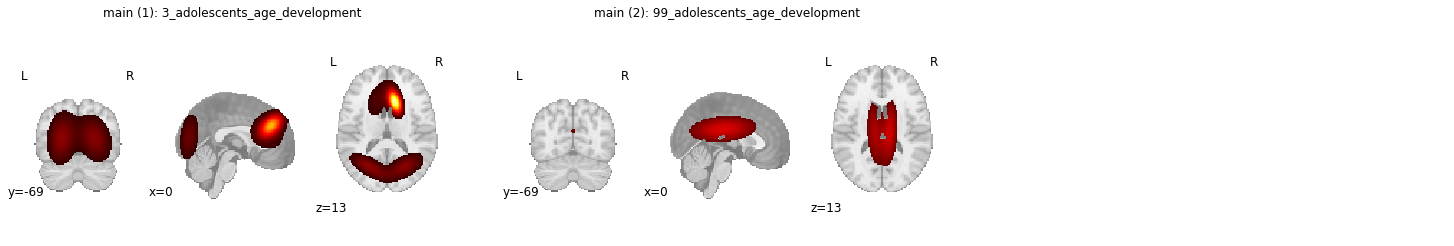

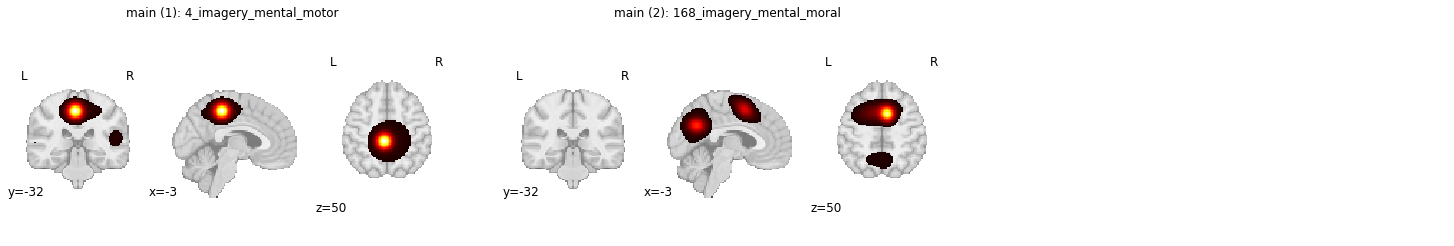

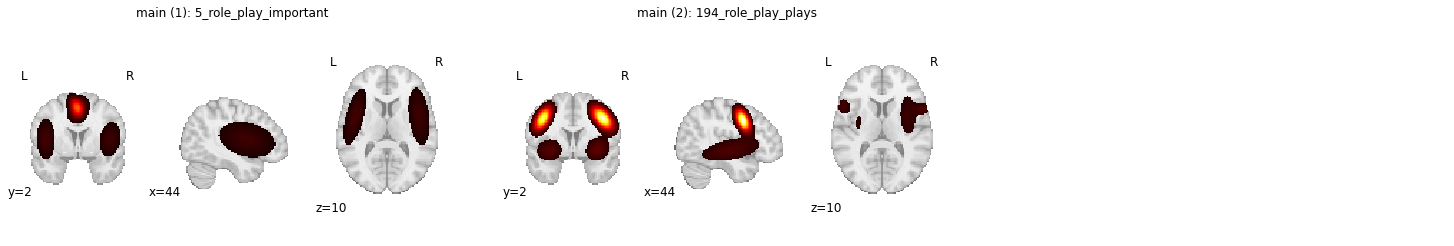

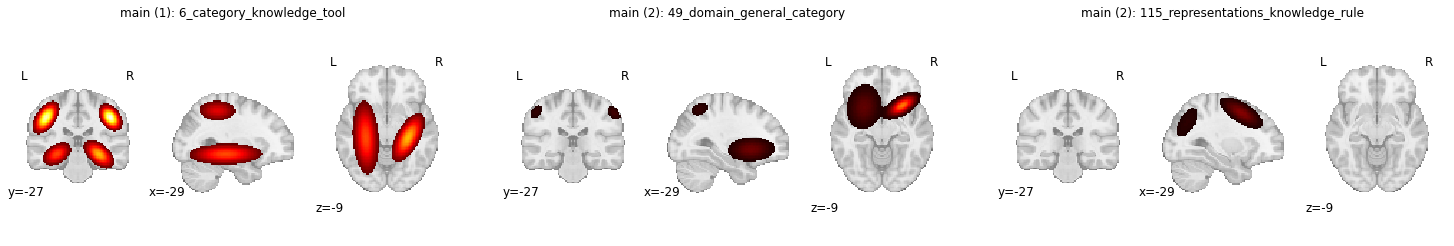

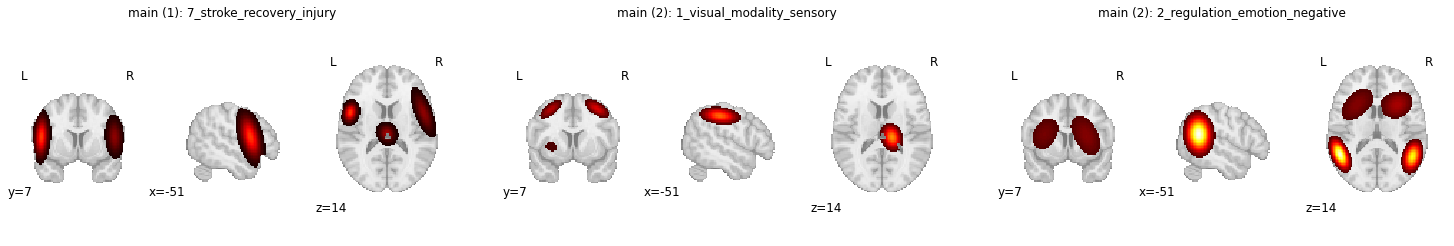

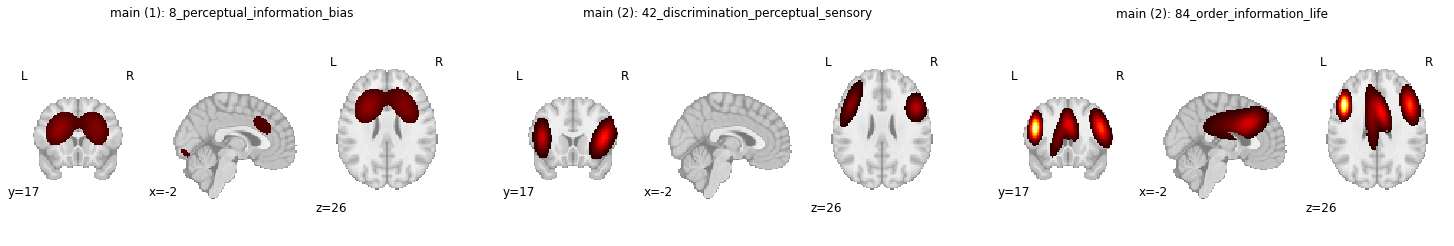

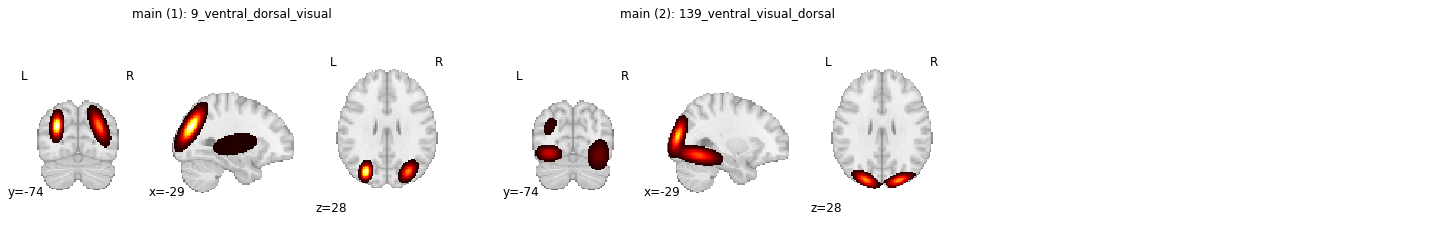

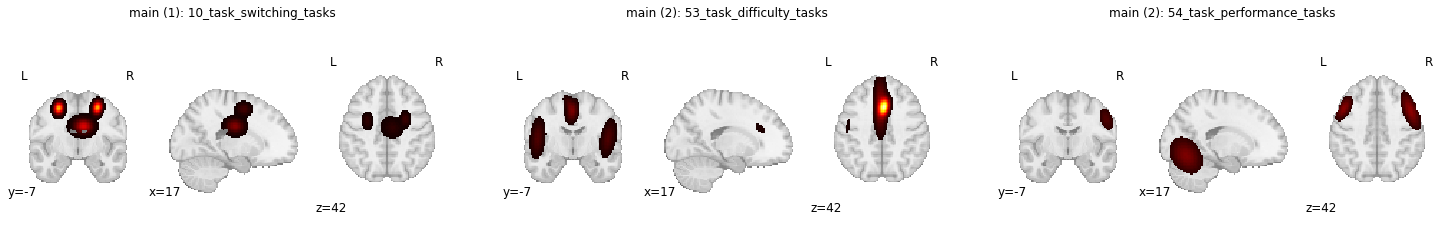

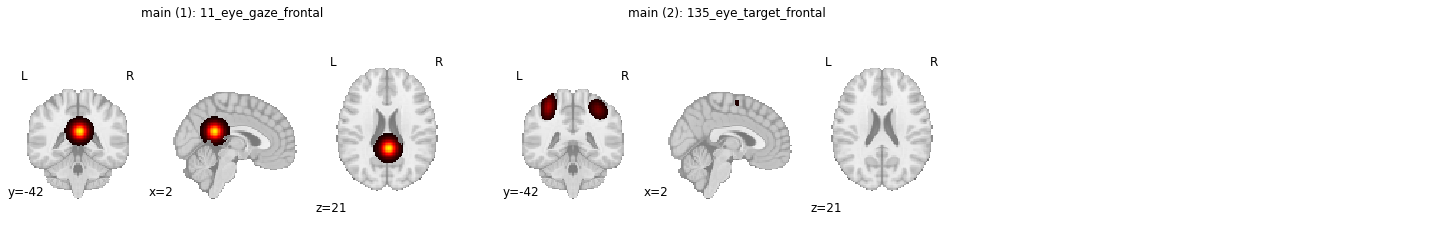

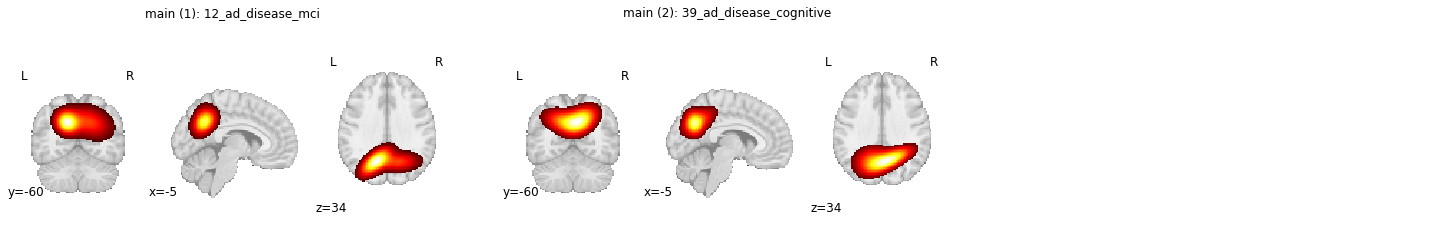

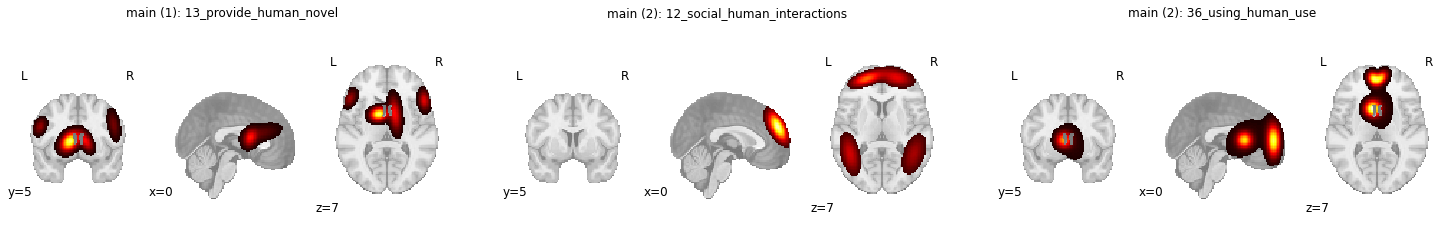

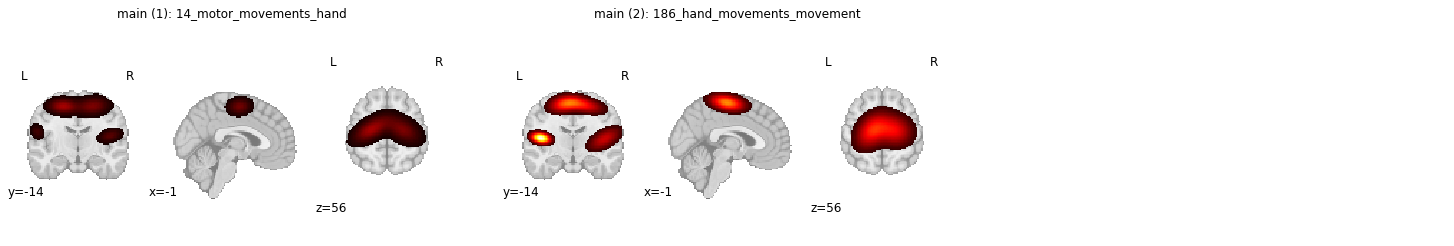

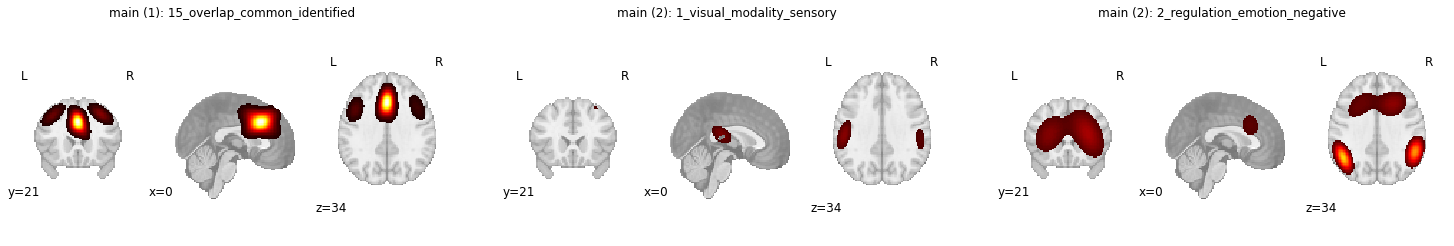

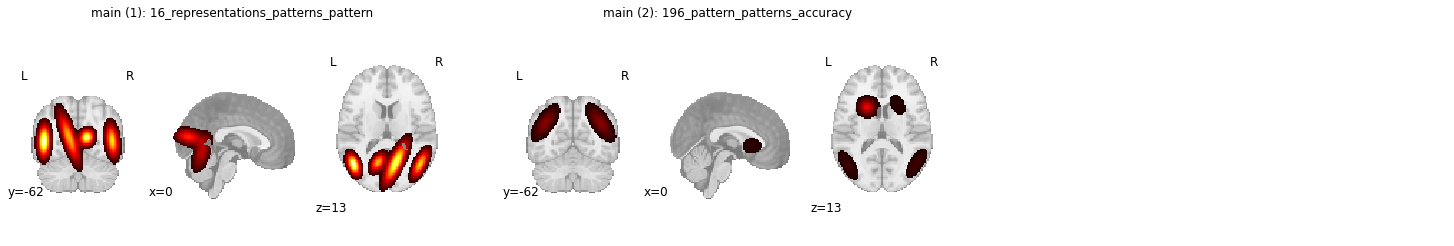

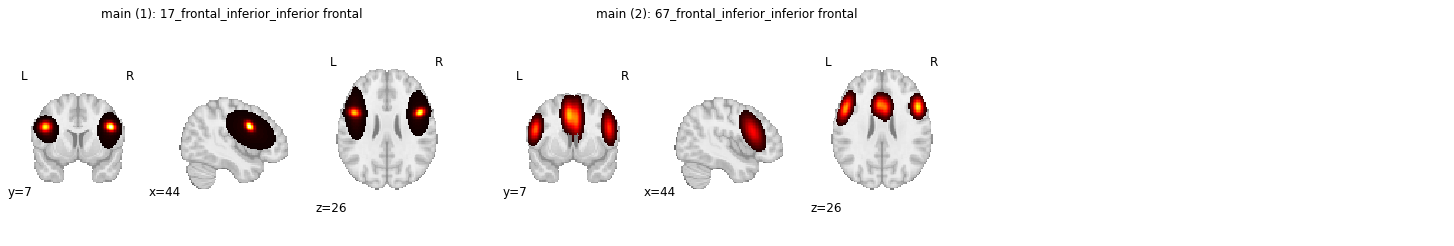

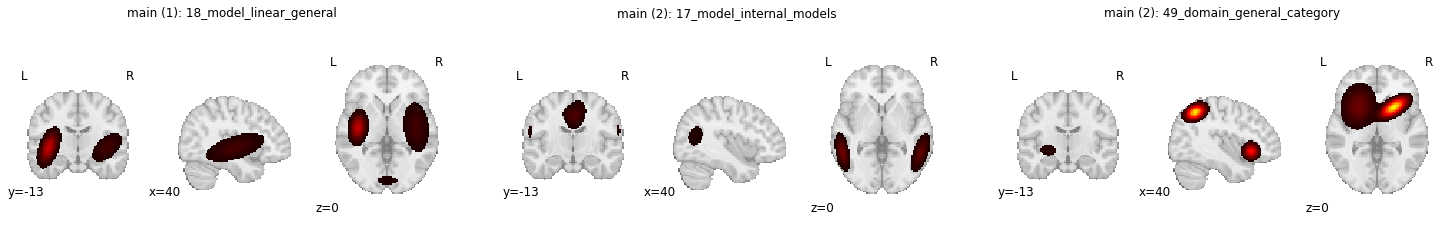

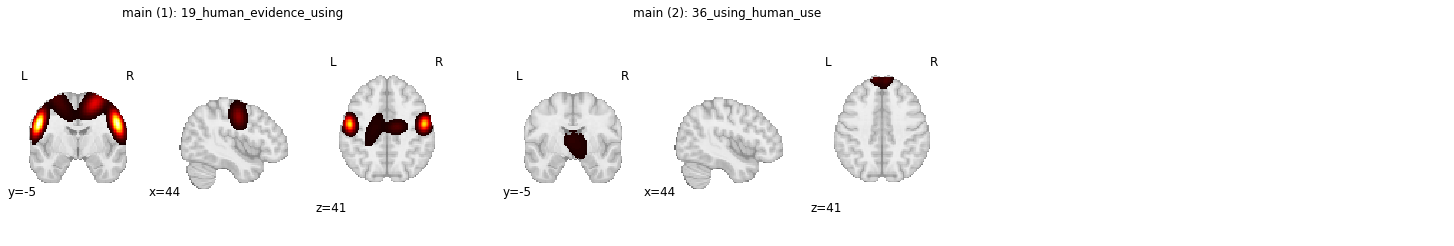

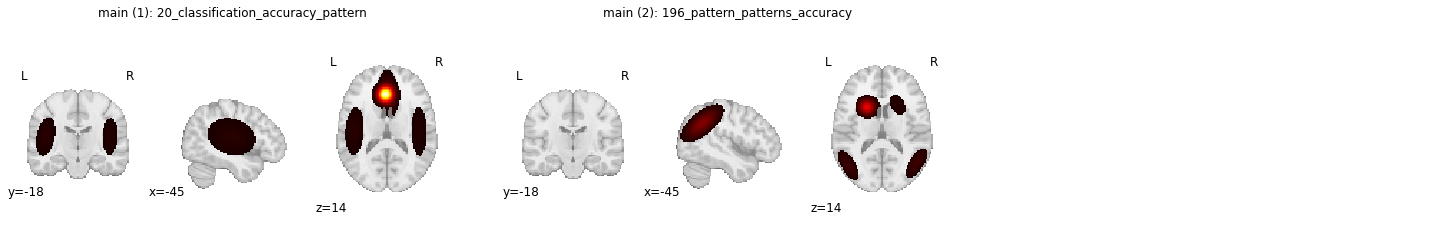

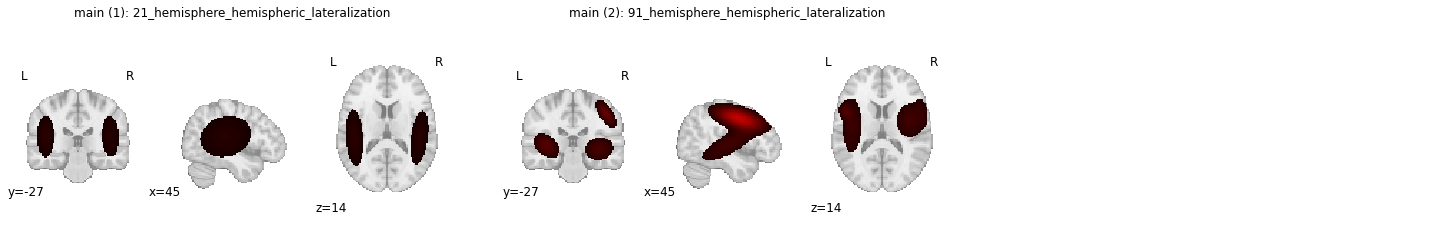

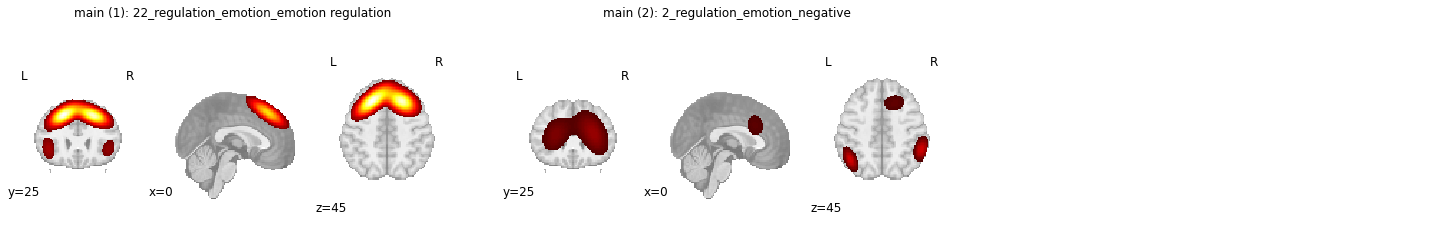

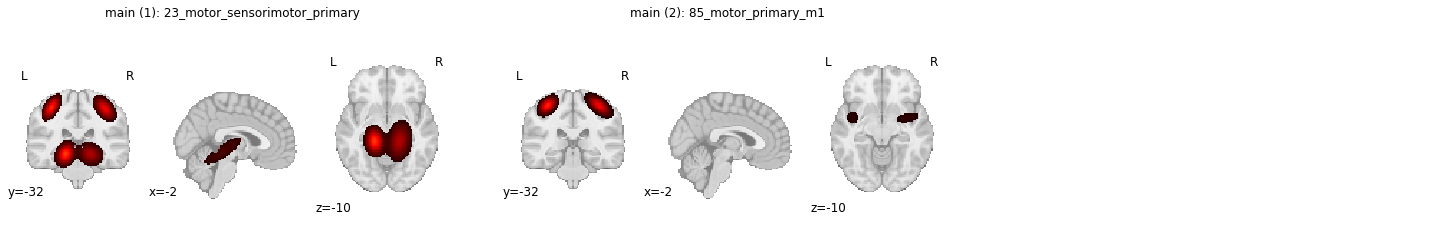

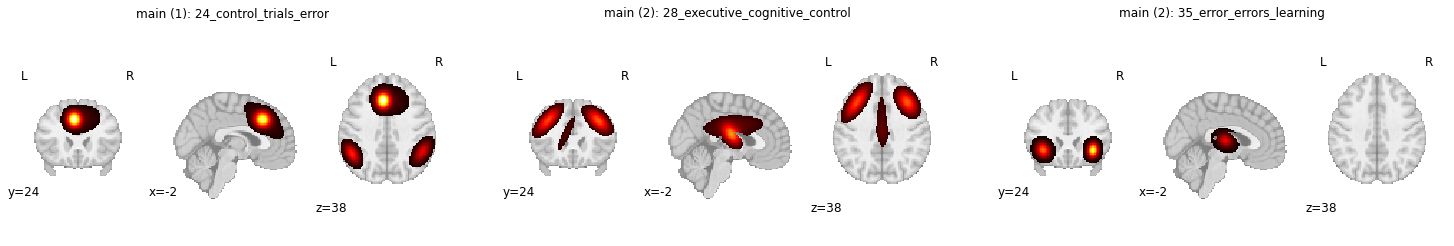

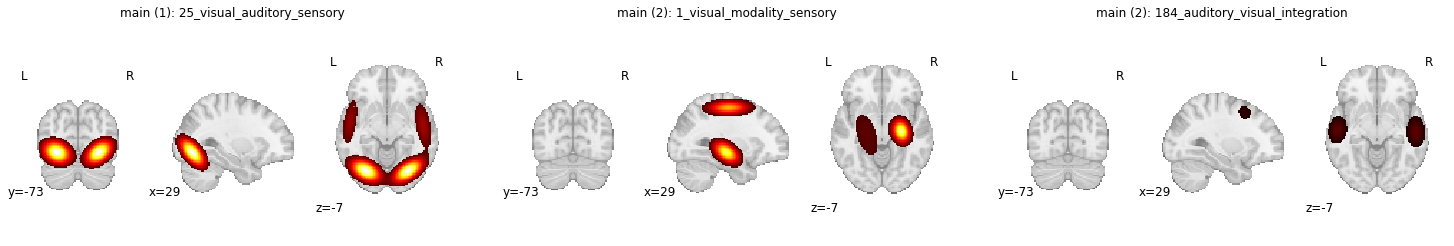

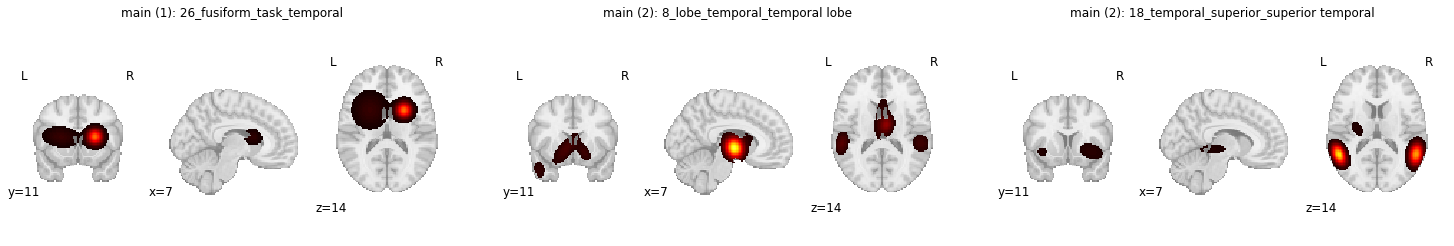

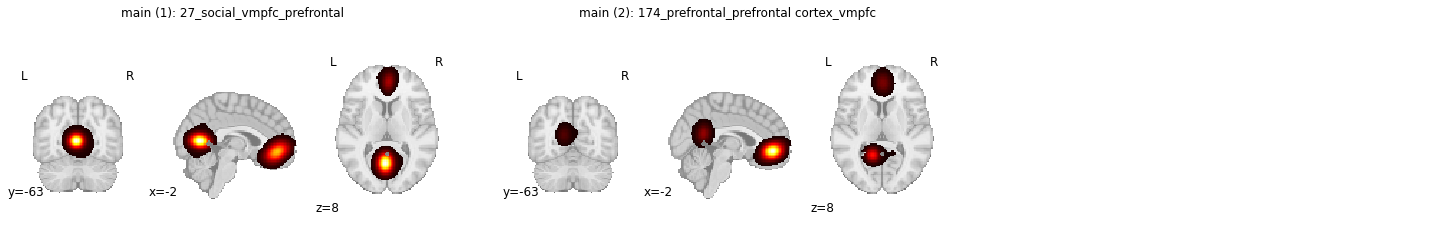

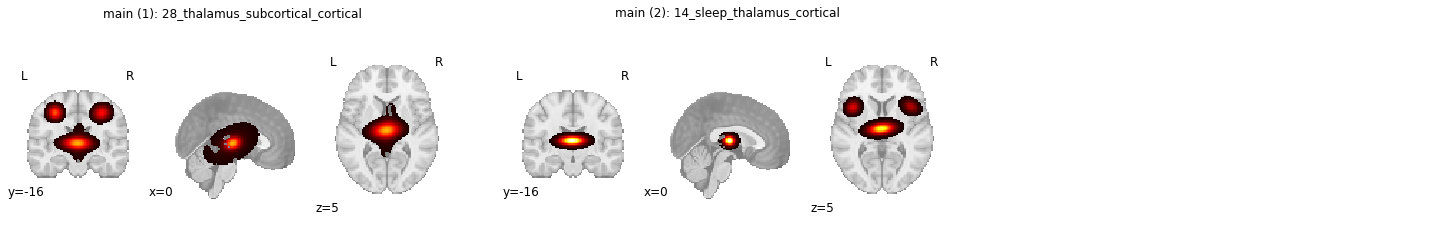

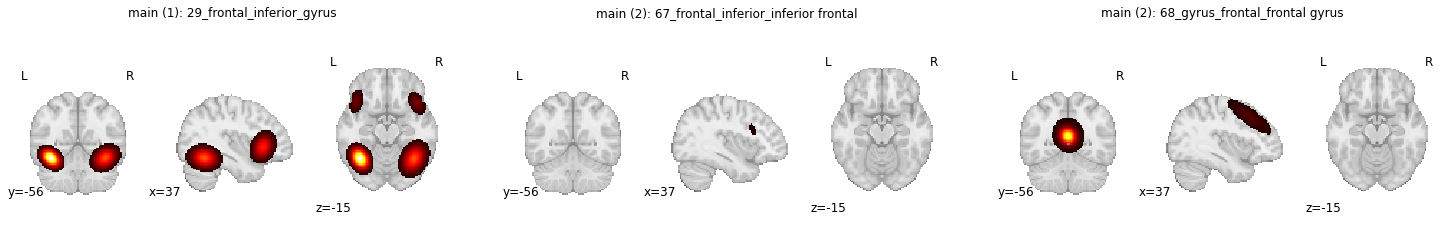

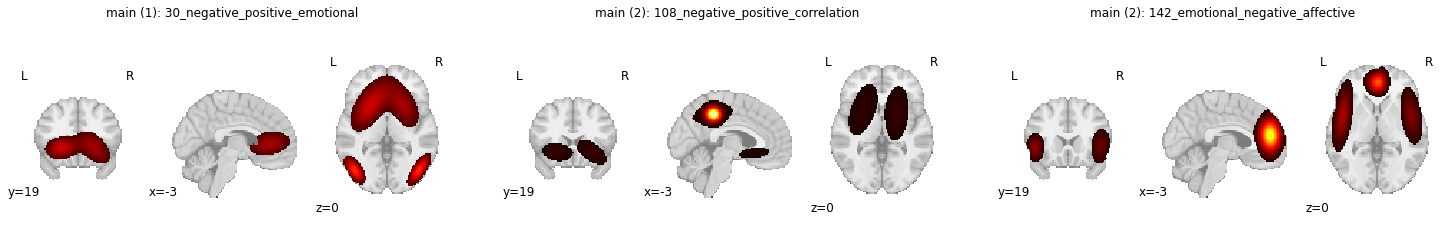

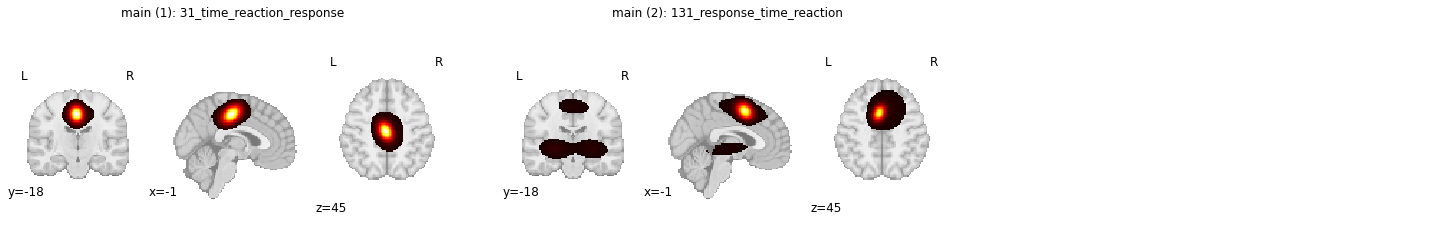

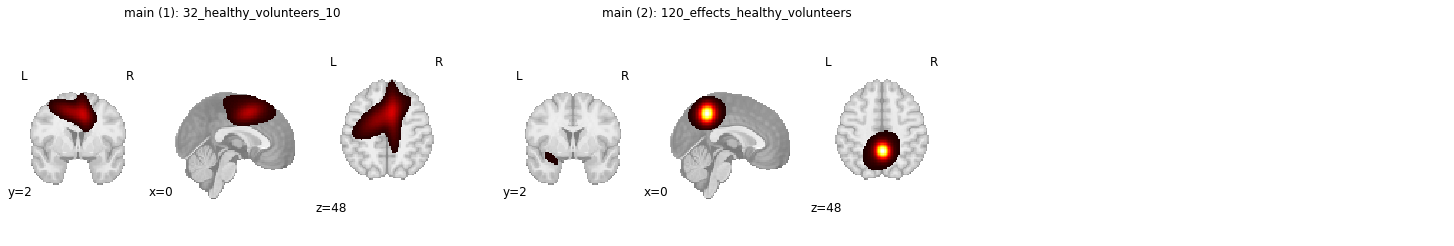

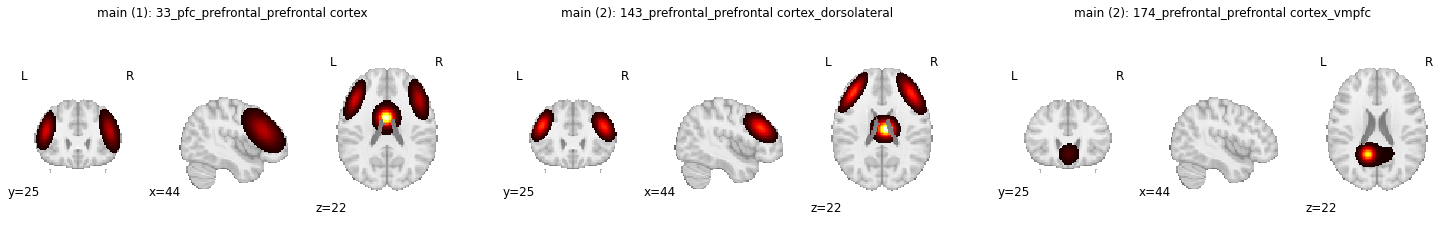

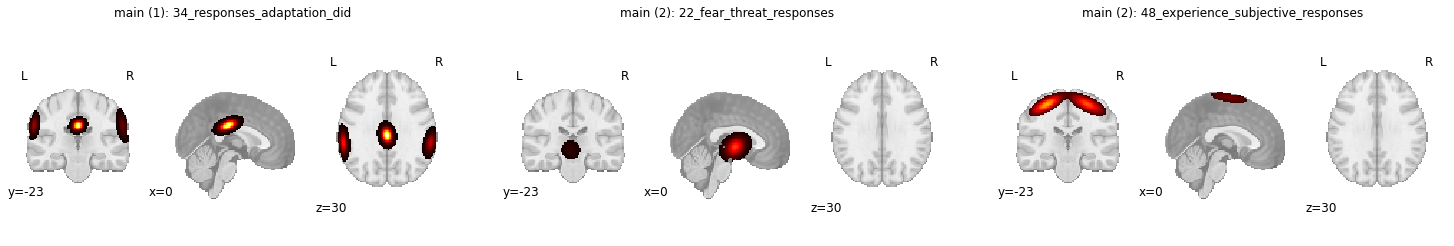

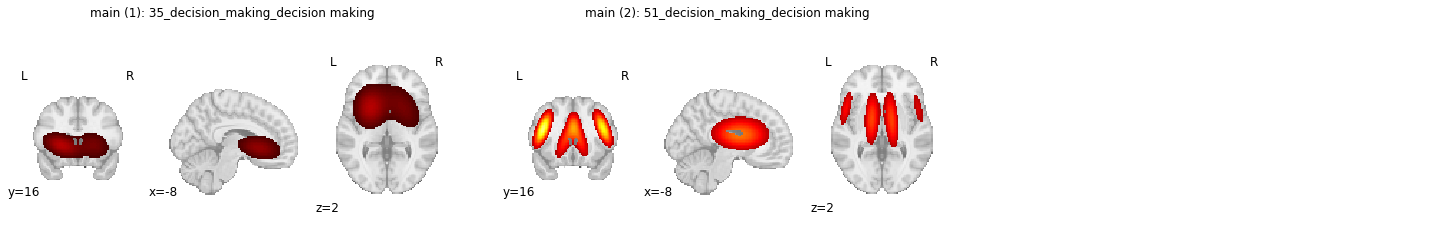

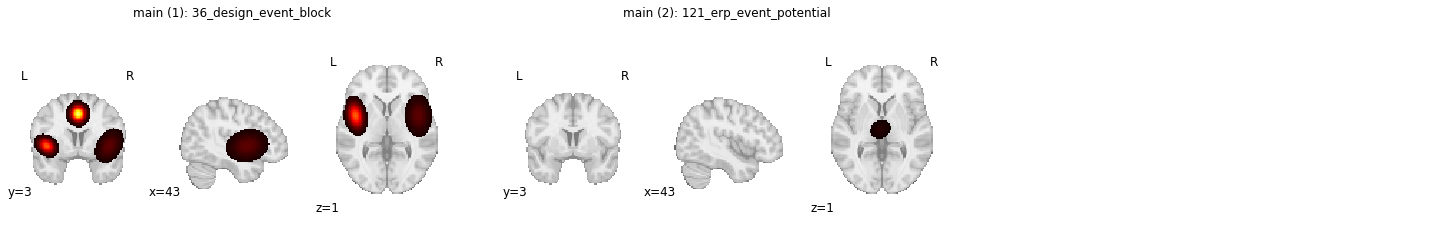

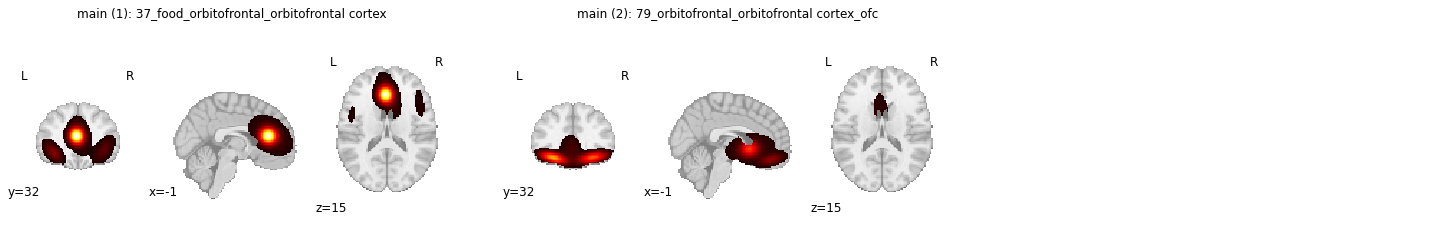

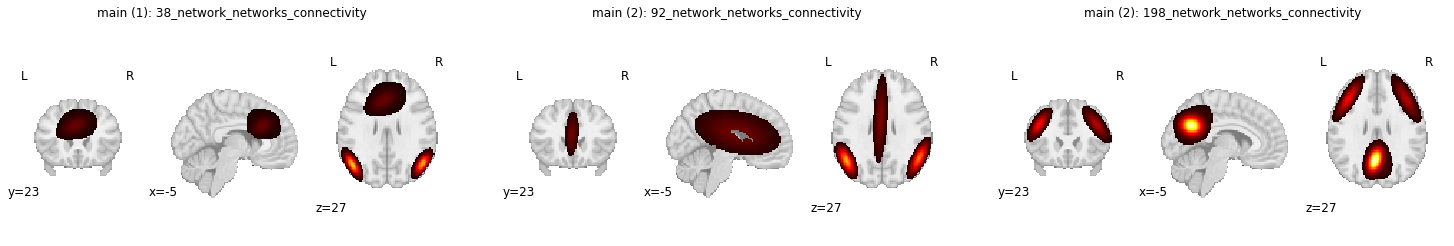

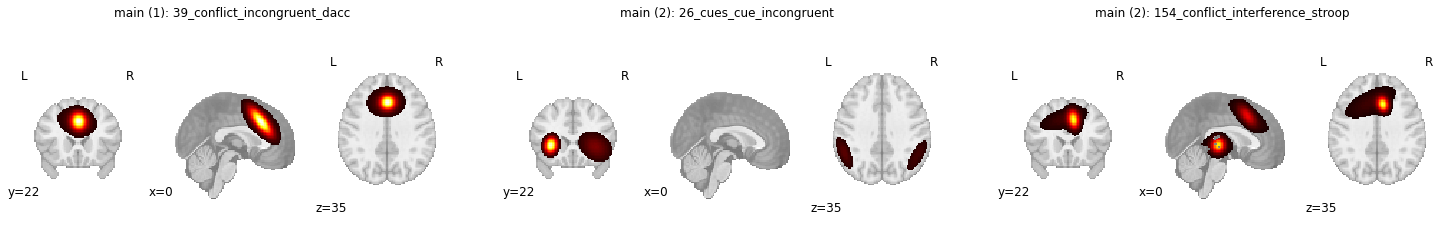

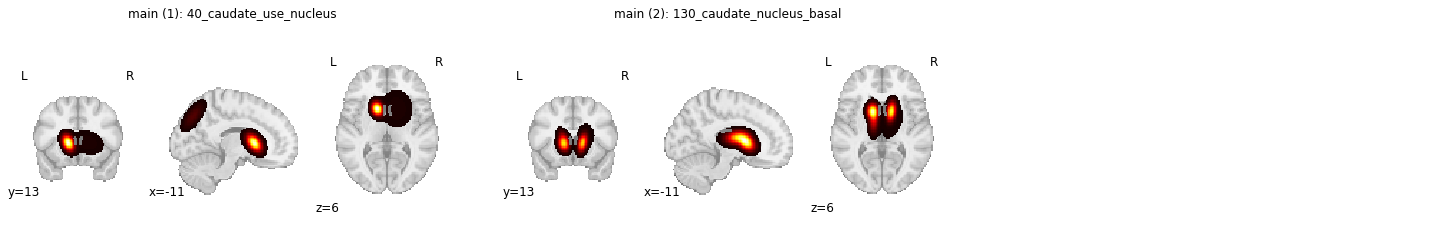

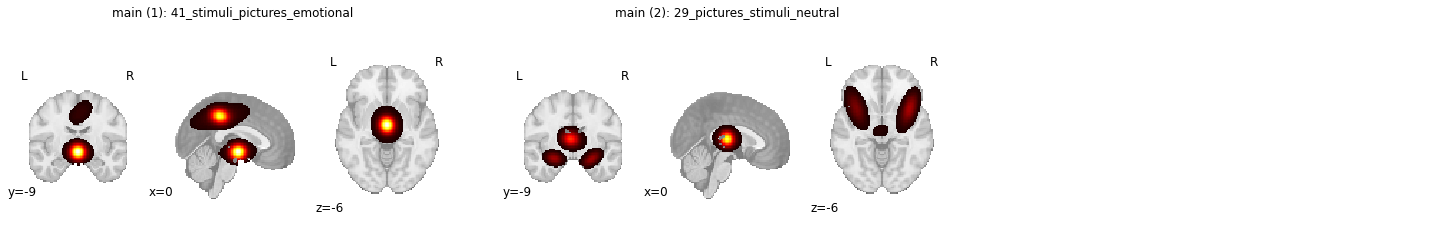

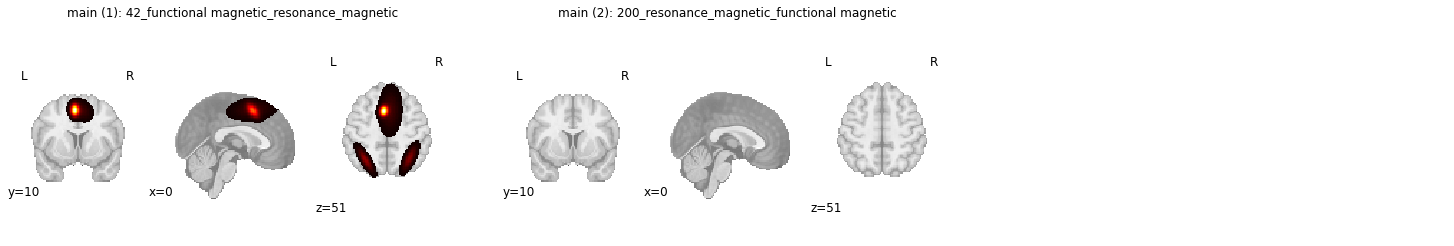

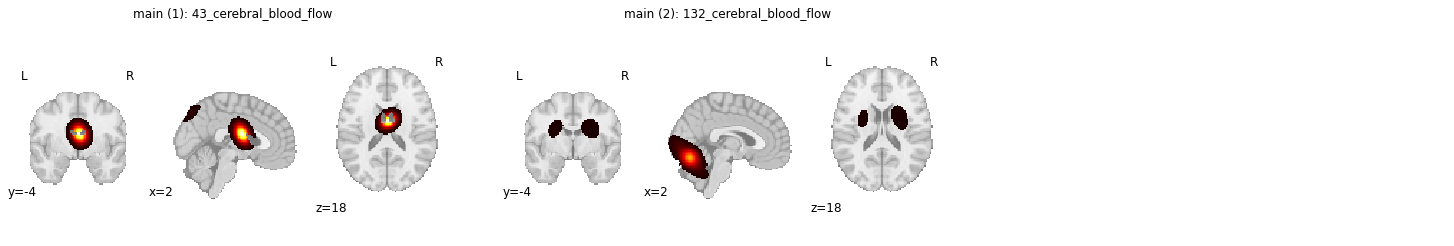

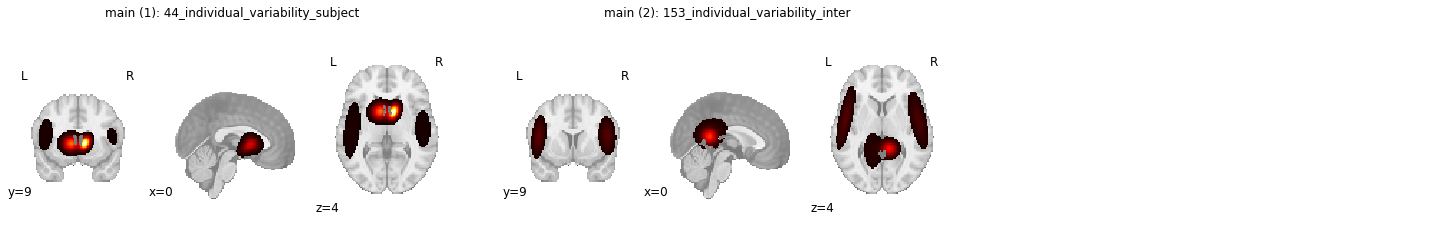

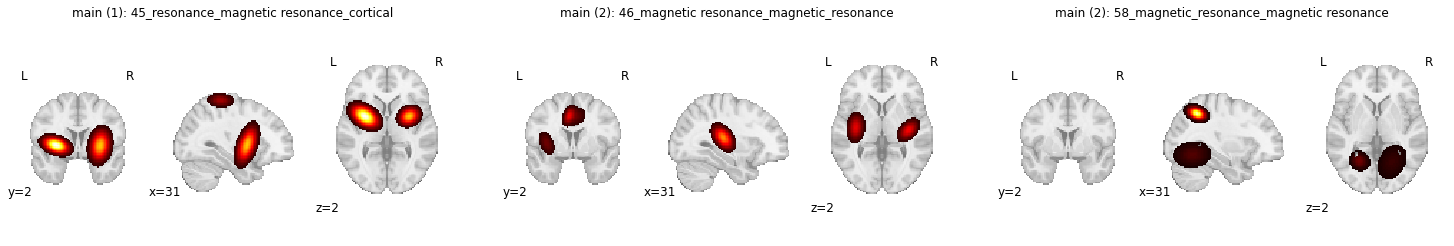

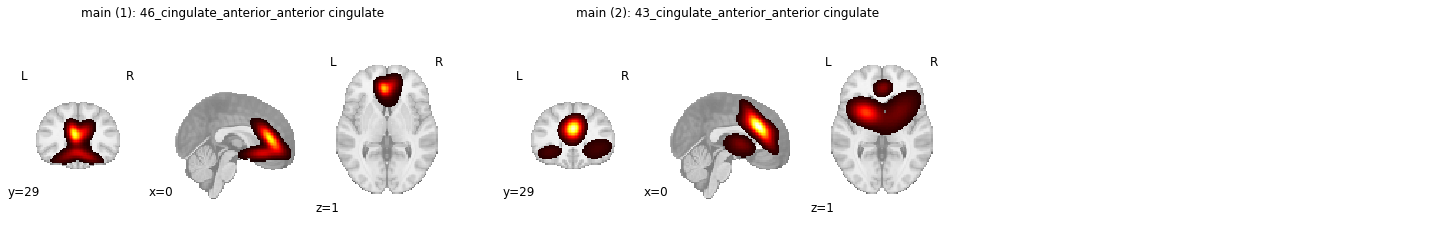

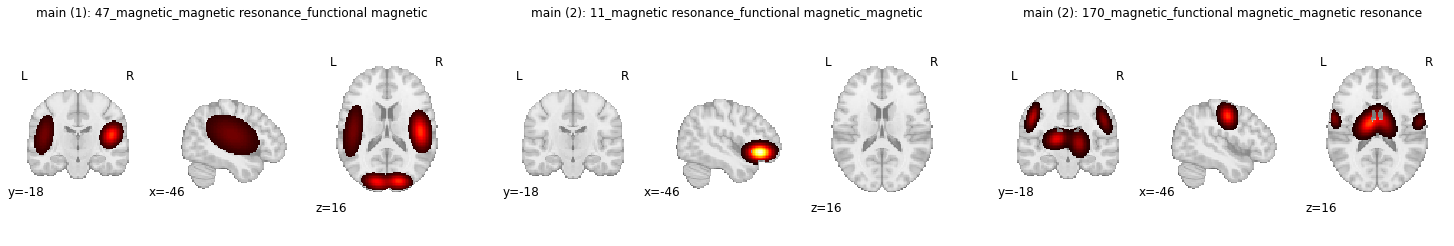

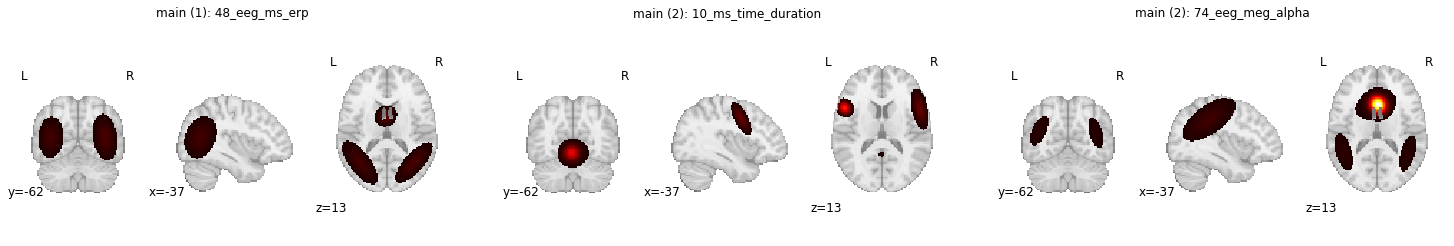

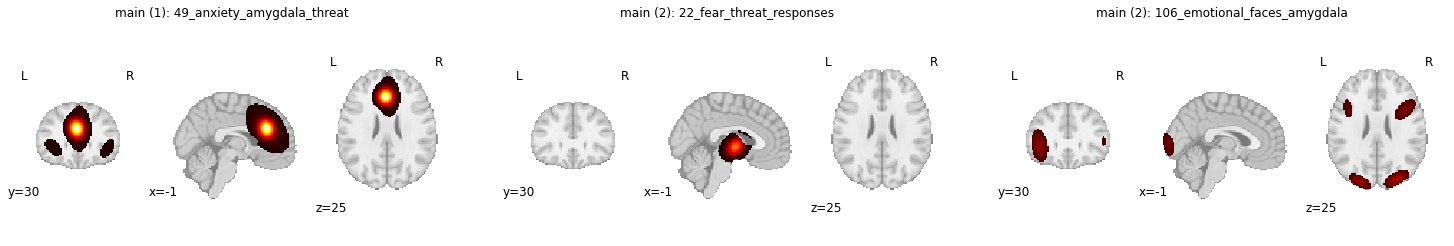

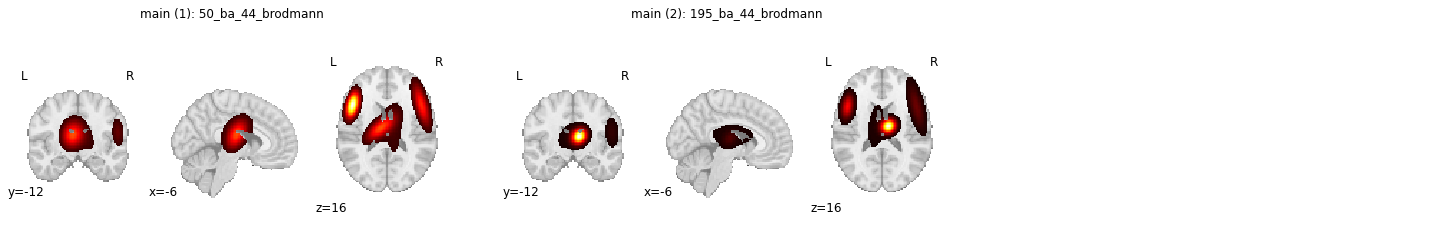

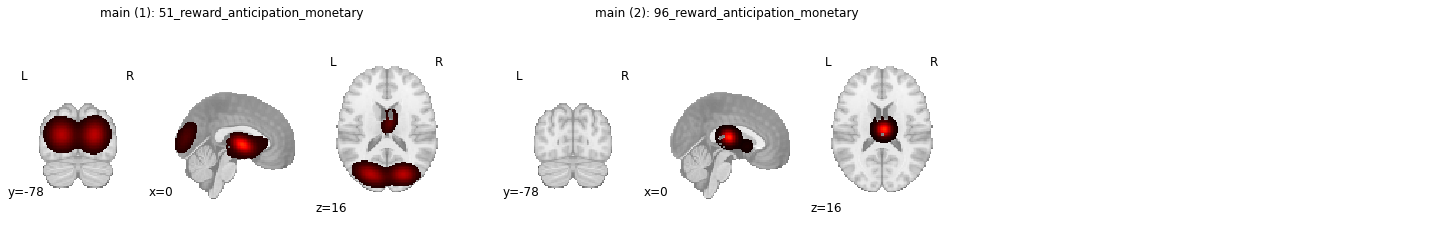

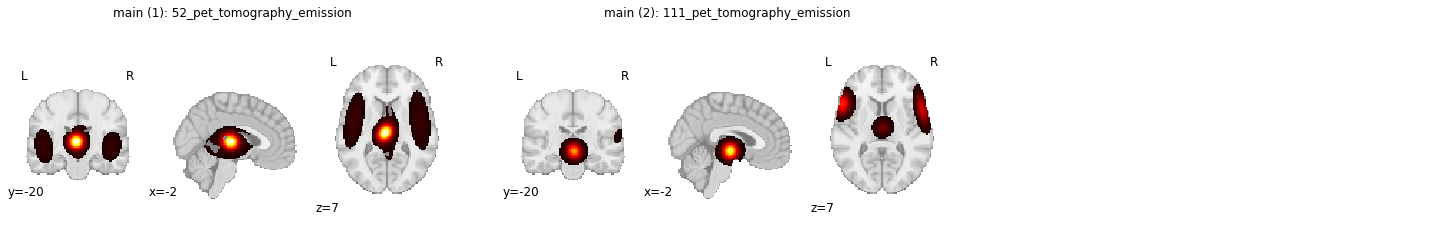

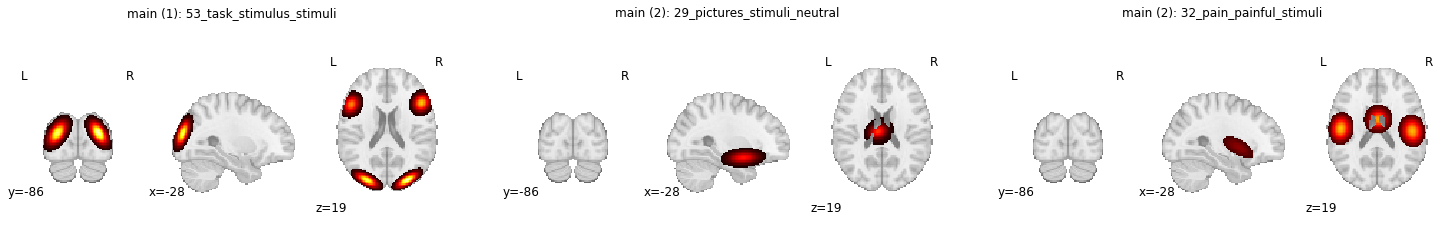

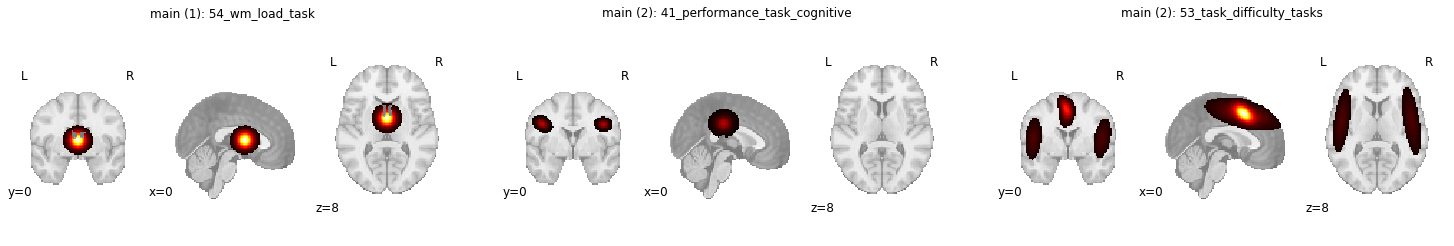

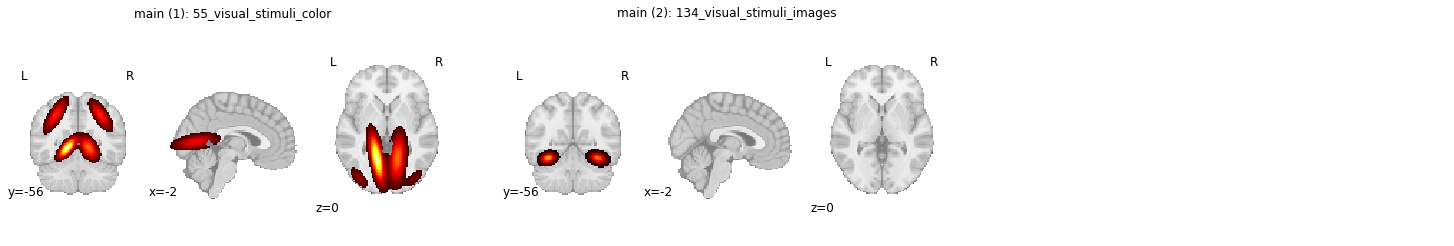

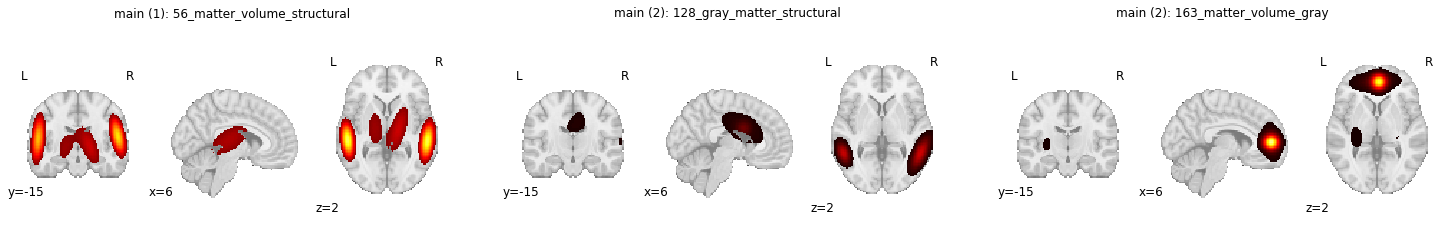

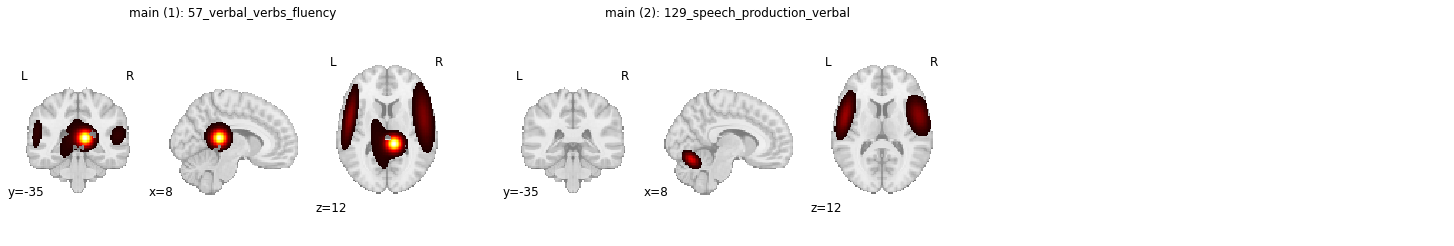

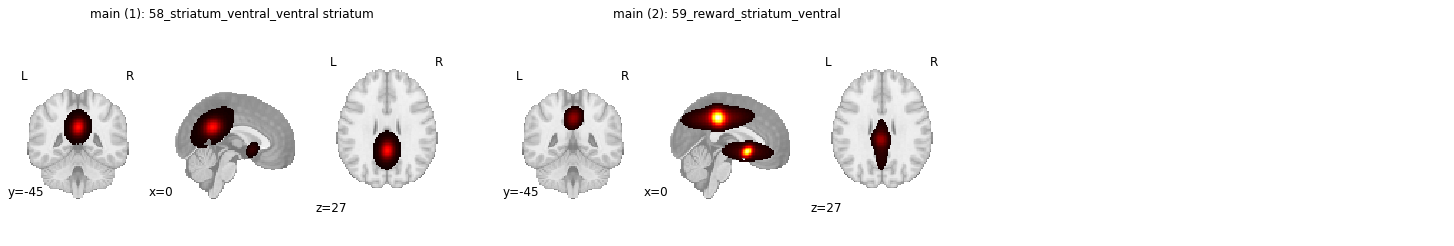

KeyboardInterrupt: 

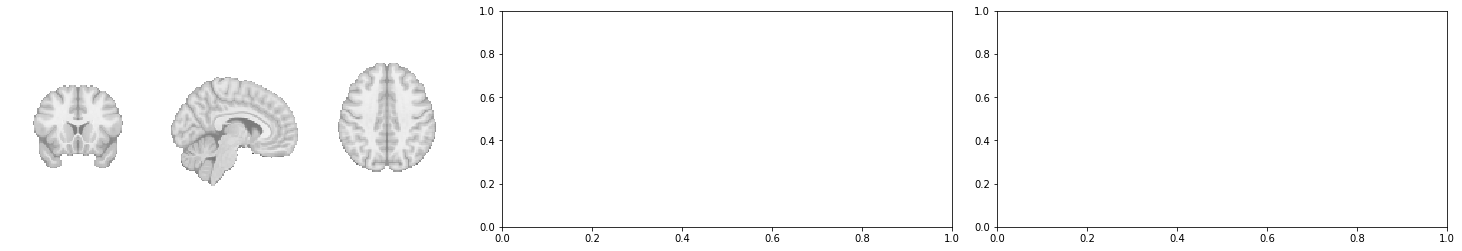

In [6]:
plot_topic_assc(
    topics_matched, 
    main1_meta_maps_imgs, 
    main1_features, 
    main2_meta_maps_imgs, 
    main2_features,
    "main (1)",
    "main (2)",
)